In [1]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import csv

dataset = 'MICC'
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if "tamp" in filename: ##1 is tampered
          images.append([filename,1])
        else:
          images.append([filename,0])
    return images

fields = ['name','score']
if dataset == 'MICC':
  images = load_images_from_folder('MICC-F2000')

  with open('MICC-F2000-images-labels.csv', 'w') as f:
      write = csv.writer(f)
      write.writerow(fields)
      write.writerows(images)

  images = load_images_from_folder('MICC-F220')

  with open('MICC-F220-images-labels.csv', 'w') as f:
      write = csv.writer(f)
      write.writerow(fields)
      write.writerows(images)

**Loading Data**

In [2]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from torchvision import transforms

batch_size = 16
class TamperDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images_list = pd.read_csv(csv_file,header=1)
        self.root_dir = root_dir
        self.transform = transform


    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):

        img_name = os.path.join(self.root_dir,
                                self.images_list.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.images_list.iloc[idx, 1]
        if self.transform:
          image = self.transform(image)
        return image,int(label)

**Applying Transformations **

In [3]:
input_size =224
batch_size = 16
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
tamper_dataset = TamperDataset(csv_file='MICC-F2000-images-labels.csv',
                                    root_dir='MICC-F2000',transform=data_transforms['train'])
tamper_dataset_val = TamperDataset(csv_file='MICC-F220-images-labels.csv',
                                    root_dir='MICC-F220',transform=data_transforms['val'])
train_loader = torch.utils.data.DataLoader(
    tamper_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
validation_loader = torch.utils.data.DataLoader(
    tamper_dataset_val, batch_size=batch_size, shuffle=True, num_workers=1)

In [4]:
dataloaders_dict = {"train": train_loader,'val': validation_loader}

Files already downloaded and verified
torch.Size([4, 3, 32, 32]) tensor([3, 5, 5, 4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


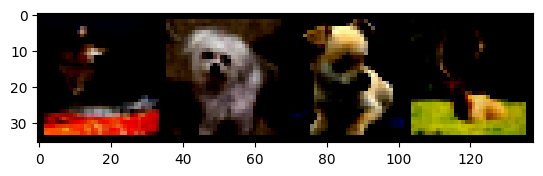

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape, labels)
imshow(torchvision.utils.make_grid(images))

**Pre Trained Model Setup for Finetuning**

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms


num_classes = 2
num_epochs = 4

feature_extract = True

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

**Choosing type of Model**

In [7]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):

    model_ft = None
    input_size = 0

    model_name == "vgg"
    """ VGG11_bn
    """
    model_ft = models.vgg11_bn(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224

    return model_ft, input_size

model_name = "vgg"

feature_extract = True

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
print(model_ft)


c:\Users\91703\anaconda3\envs\try\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\91703\anaconda3\envs\try\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [8]:
from keras.applications.vgg16 import VGG16
from keras.utils import plot_model

model = VGG16()

plot_model(model, to_file='vgg_model.png', show_shapes=True, show_layer_names=True)


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


**Visualising layers**

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

DROP_LAYERS = False
if DROP_LAYERS:
  feats_list = list(model_ft.features)
  new_feats_list = []
  for feat in feats_list:
      new_feats_list.append(feat)
      if isinstance(feat, nn.Conv2d):
          new_feats_list.append(nn.Dropout(p=0.5, inplace=True))

  model_ft.features = nn.Sequential(*new_feats_list)
  print("Params updated:")

  for name,param in model_ft.named_parameters():
          if param.requires_grad == True:
              print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)

class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = list(model.features)
        self.features = nn.Sequential(*self.features)
        self.pooling = model.avgpool
        self.flatten = nn.Flatten()
        self.fc = model.classifier[0]

    def forward(self, x):
        out = self.features(x)
        out = self.pooling(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out

model_vgg = models.vgg19(pretrained=True)
new_model = FeatureExtractor(model_vgg)
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
new_model = new_model.to(device)
phase = 'train'
dataloaders_dict = {'train': train_loader}
feature_list = []
for inputs, labels in dataloaders_dict[phase]:
    inputs = inputs.to(device)
    for img in inputs:
        feature = new_model(img.unsqueeze(0))
        feature_list.append(feature.cpu().detach().numpy().reshape(-1))


Files already downloaded and verified


c:\Users\91703\anaconda3\envs\try\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Training Model**

In [11]:
from torch.utils.data import random_split

val_size = 5000
train_size = len(train_set) - val_size
train_dataset, val_dataset = random_split(train_set, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
dataloaders_dict = {'train': train_loader, 'val': val_loader}

import time
import os
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                labels = labels % num_classes
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
num_epochs = 30
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs, is_inception=(model_name == "inception"))

Epoch 0/29
----------
train Loss: 3.4361 Acc: 0.6111
val Loss: 4.7836 Acc: 0.6388

Epoch 1/29
----------
train Loss: 3.7035 Acc: 0.6202
val Loss: 2.9581 Acc: 0.6976

Epoch 2/29
----------
train Loss: 3.7462 Acc: 0.6163
val Loss: 3.4975 Acc: 0.6554

Epoch 3/29
----------
train Loss: 3.7175 Acc: 0.6197
val Loss: 4.2563 Acc: 0.6288

Epoch 4/29
----------
train Loss: 3.7579 Acc: 0.6134
val Loss: 3.1878 Acc: 0.6764

Epoch 5/29
----------
train Loss: 3.7312 Acc: 0.6160
val Loss: 3.7654 Acc: 0.6412

Epoch 6/29
----------
train Loss: 3.7003 Acc: 0.6177
val Loss: 2.7260 Acc: 0.6886

Epoch 7/29
----------
train Loss: 3.7433 Acc: 0.6139
val Loss: 3.3425 Acc: 0.6700

Epoch 8/29
----------
train Loss: 3.7561 Acc: 0.6103
val Loss: 3.4358 Acc: 0.6672

Epoch 9/29
----------
train Loss: 3.7520 Acc: 0.6128
val Loss: 3.7396 Acc: 0.6494

Epoch 10/29
----------
train Loss: 3.7966 Acc: 0.6098
val Loss: 4.1601 Acc: 0.6282

Epoch 11/29
----------
train Loss: 3.7491 Acc: 0.6160
val Loss: 5.3446 Acc: 0.6114

Ep


Saved model to model_vgg_feat30.pth.


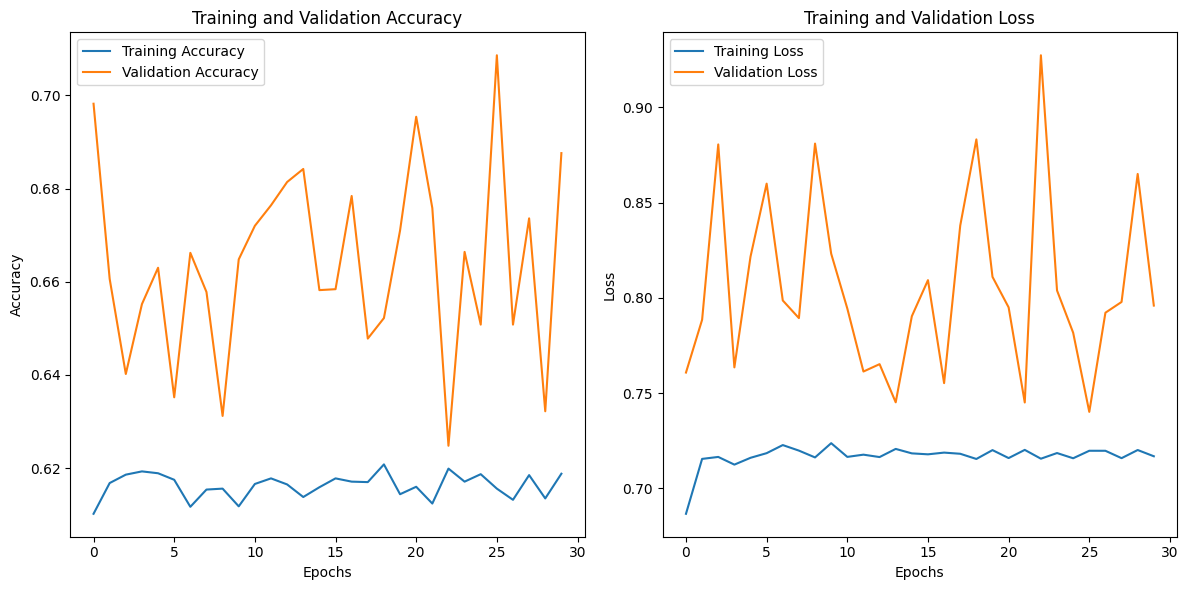

In [13]:
model_file = 'model_vgg_feat' + str(num_epochs) + '.pth'
torch.save(model_ft.state_dict(), model_file)
print('\nSaved model to ' + model_file + '.')

import matplotlib.pyplot as plt

epochs = list(range(30))
train_acc = [0.6102, 0.6168, 0.6186, 0.6193, 0.6189, 0.6175, 0.6117, 0.6154, 0.6156, 0.6118, 0.6166, 0.6178, 0.6165, 0.6138, 0.6159, 0.6178, 0.6171, 0.6170, 0.6208, 0.6144, 0.6160, 0.6124, 0.6199, 0.6171, 0.6187, 0.6156, 0.6132, 0.6185, 0.6135, 0.6188]
val_acc = [0.6982, 0.6606, 0.6402, 0.6552, 0.6630, 0.6352, 0.6662, 0.6578, 0.6312, 0.6648, 0.6720, 0.6764, 0.6814, 0.6842, 0.6582, 0.6584, 0.6784, 0.6478, 0.6522, 0.6710, 0.6954, 0.6758, 0.6248, 0.6664, 0.6508, 0.7086, 0.6508, 0.6736, 0.6322, 0.6876]
train_loss = [0.68657, 0.71541, 0.71644, 0.7124, 0.71598, 0.71842, 0.72267, 0.71976, 0.71618, 0.72366, 0.71646, 0.71763, 0.71637, 0.72065, 0.71831, 0.71781, 0.71871, 0.7181, 0.71537, 0.72002, 0.71584, 0.72014, 0.71551, 0.71848, 0.71574, 0.71968, 0.71967, 0.71579, 0.72007, 0.71679]
val_loss = [0.76076, 0.7885, 0.88059, 0.76348, 0.82164, 0.86, 0.79863, 0.78936, 0.88103, 0.82321, 0.79441, 0.7613, 0.76517, 0.74513, 0.79034, 0.8093, 0.75521, 0.83795, 0.88323, 0.81102, 0.795, 0.74504, 0.92743, 0.80388, 0.78169, 0.7401, 0.7922, 0.79784, 0.86508, 0.79594]


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


**Display images in dataset**


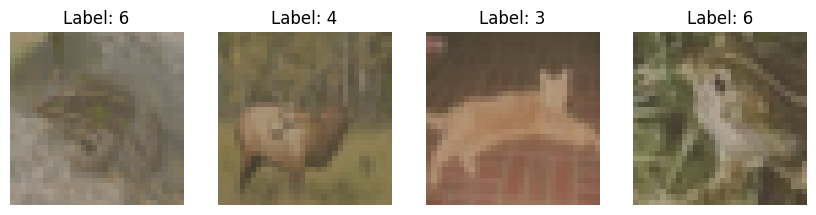

In [14]:
def showimages(imgs,actual_lbls,pred_lbls=None):

  fig = plt.figure(figsize=(21,12))

  for i,img in enumerate(imgs):

    fig.add_subplot(4,8, i+1)
    y=actual_lbls[i]

    if pred_lbls!=None:
      y_pre=pred_lbls[i]
      title="prediction: {0}\nlabel:{1}".format(y,y_pre)
    else:
      title="Label: {0}".format(y)

    plt.title(title)
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.axis("off")
    plt.imshow(img)

plt.show()

inputs, classes = next(iter(train_loader))

showimages(inputs,classes)

**Predicting results and showing.**

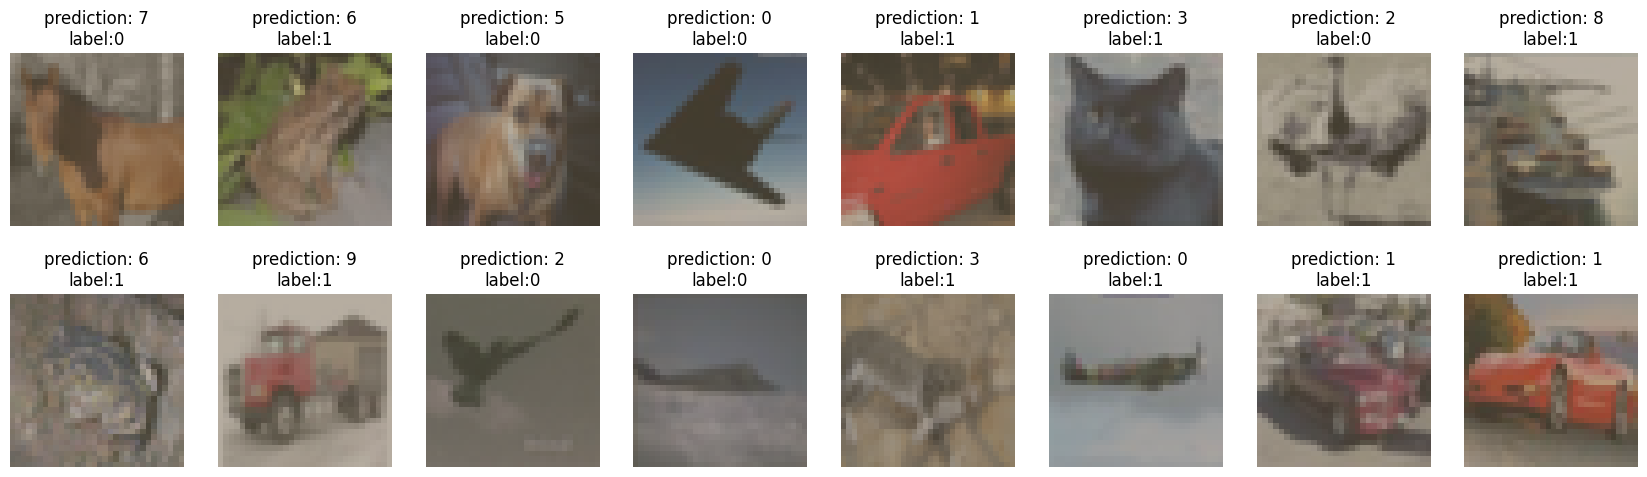

In [15]:
import torch
import torch.multiprocessing as mp
from torch.utils.data import DataLoader

def predict_images(model, images, actual_label):
    model.eval()
    with torch.no_grad():
        inputs = images.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        showimages(images, actual_label, preds.cpu())

if __name__ == '__main__':
    try:
        mp.set_start_method('spawn')
    except RuntimeError:
        pass  # Ignore if the context has already been set
    validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    images, classes = next(iter(validation_loader))
    predict_images(model_ft, images, classes)


**Approach 2:**
Using CNN and SVM with patch features, Explained in detail in the report.

Extracting masks(ground truth) from Tampered images using authentic.

In [16]:
import os
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
import csv
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity

def find_mask(sp_pic, au_pic_dict):
    background_index = [13, 21]
    save_name = sp_pic.split("/")[-1][:-4]  # name of the mask
    sp_name = sp_pic.split("/")[-1][background_index[0]:background_index[1]]
    if sp_name in au_pic_dict.keys():
        au_pic = au_pic_dict[sp_name]
        if os.path.exists(au_pic) and os.path.exists(sp_pic):
            au_image = plt.imread(au_pic)
            sp_image = plt.imread(sp_pic)
            if sp_image.shape == au_image.shape:
                # convert images to grayscale
                gray_au_image = cv2.cvtColor(au_image, cv2.COLOR_BGR2GRAY)
                gray_sp_image = cv2.cvtColor(sp_image, cv2.COLOR_BGR2GRAY)
                # get the difference of the 2 grayscale images
                (_, diff) = structural_similarity(gray_au_image, gray_sp_image, full=True)
                diff = cv2.medianBlur(diff, 1)
                # make background black and tampered area white
                mask = np.ones_like(diff)
                mask[diff < 0.98] = 1
                mask[diff >= 0.98] = 0
                mask = (mask * 255).astype("uint8")
                mask_file = 'CASIA2/masks/' + save_name + '_gt.png'
                cv2.imwrite(mask_file, mask)  # save the mask file


def extract_masks():
    save_dir = 'CASIA2/masks/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    else:
        return
    au_pic_list = glob('CASIA2/Au/*')
    sp_pic_list = glob('CASIA2/Tp/*')
    au_index = [3, 6, 7, 12]
    au_pic_dict = {au_pic.split("/")[-1][au_index[0]:au_index[1]] + au_pic.split("/")[-1][au_index[2]:au_index[3]]:au_pic for au_pic in au_pic_list}
    for _, Sp_pic in enumerate(sp_pic_list):
        find_mask(Sp_pic, au_pic_dict)

extract_masks()





**Extract patches. rot: for rotation, no_rot: normal **

In [17]:
from patch_extraction.patch_extractor_casia import PatchExtractorCASIA

patchs = PatchExtractorCASIA(input_path='CASIA2', output_path='casia/CASIA2/patches/',patches_per_image=2, stride=128, rotations=4, mode='no_rot')
patchs.extract_patches()



Could not find a backend to open `CASIA2/Tp/Thumbs.db`` with iomode `r`.
Number of tampered patches for image Tp_D_CND_M_N_ani00018_sec00096_00138 is only 0
Number of tampered patches for image Tp_D_CNN_M_N_art00052_arc00030_11853 is only 1
Number of tampered patches for image Tp_D_CNN_M_N_nat00013_cha00042_11093 is only 1
Number of tampered patches for image Tp_D_CNN_M_N_pla00042_pla00042_10976 is only 0
Number of tampered patches for image Tp_D_CNN_M_N_sec10107_sec10101_10299 is only 0
Number of tampered patches for image Tp_D_CNN_M_N_sec10110_sec10101_10298 is only 1
Number of tampered patches for image Tp_D_CNN_S_B_txt00055_txt00047_11328 is only 0
Number of tampered patches for image Tp_D_CNN_S_N_cha00044_cha00043_00364 is only 1
Number of tampered patches for image Tp_D_CNN_S_N_nat00035_nat00035_00649 is only 0
Number of tampered patches for image Tp_D_CNN_S_N_txt00043_txt00051_10378 is only 1
Number of tampered patches for image Tp_D_CRD_M_B_arc10113_arc10112_10030 is only 1
Num

In [18]:
##training
import torch
import tensorflow
import pandas as pd
import torchvision.transforms as transforms
from torchvision import datasets
from cnn.cnn import CNN
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
import time
import numpy as np

train_set = datasets.ImageFolder(root="C:\\College\\Major Project\\Immmm\\Deep-Learning-Based-Tamper-Detection-on-Images-master\\Deep-Learning-Based-Tamper-Detection-on-Images-master\\casia\\CASIA2\\patches\\", transform=transforms.Compose([transforms.ToTensor()]))  # Fetch data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if str(device) == "cuda:0":
    net = CNN().cuda()
else:
    net = CNN()

from torchsummary import summary

if str(device) == "cuda:0":
    net = CNN().cuda()
else:
    net = CNN()

summary(net, (3, 128, 128))

# from torchviz import make_dot

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# net.to(device)
# inputs = torch.randn(1, 3, 128, 128).to(device)
# make_dot(net(inputs), params=dict(net.named_parameters()))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 124, 124]             228
            Conv2d-2           [-1, 30, 60, 60]           2,280
         MaxPool2d-3           [-1, 30, 30, 30]               0
            Conv2d-4           [-1, 16, 28, 28]           4,336
            Conv2d-5           [-1, 16, 26, 26]           2,320
            Conv2d-6           [-1, 16, 24, 24]           2,320
            Conv2d-7           [-1, 16, 22, 22]           2,320
         MaxPool2d-8           [-1, 16, 11, 11]               0
            Conv2d-9             [-1, 16, 9, 9]           2,320
           Conv2d-10             [-1, 16, 7, 7]           2,320
           Conv2d-11             [-1, 16, 5, 5]           2,320
           Linear-12                    [-1, 2]             802
Total params: 21,566
Trainable params: 21,566
Non-trainable params: 0
---------------------------------

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

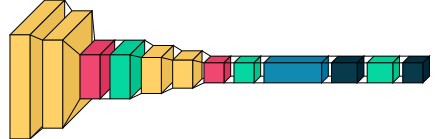

In [19]:
n_epochs = 15
batch_size = 128
learning_rate = 0.0001

**Training the CNN**

######### Epoch 1 Loss: 0.692 Accuracy: 0.918 Time: 35.347 #########
######### Epoch 2 Loss: 0.694 Accuracy: 0.918 Time: 28.351 #########
######### Epoch 3 Loss: 0.694 Accuracy: 0.918 Time: 28.111 #########
######### Epoch 4 Loss: 0.693 Accuracy: 0.918 Time: 27.058 #########
######### Epoch 5 Loss: 0.693 Accuracy: 0.922 Time: 22.651 #########
######### Epoch 6 Loss: 0.693 Accuracy: 0.924 Time: 23.701 #########
######### Epoch 7 Loss: 0.693 Accuracy: 0.922 Time: 22.538 #########
######### Epoch 8 Loss: 0.693 Accuracy: 0.921 Time: 22.564 #########
######### Epoch 9 Loss: 0.693 Accuracy: 0.920 Time: 21.445 #########
######### Epoch 10 Loss: 0.693 Accuracy: 0.920 Time: 21.359 #########
######### Epoch 11 Loss: 0.693 Accuracy: 0.923 Time: 21.590 #########
######### Epoch 12 Loss: 0.693 Accuracy: 0.920 Time: 21.314 #########
######### Epoch 13 Loss: 0.693 Accuracy: 0.922 Time: 21.591 #########
######### Epoch 14 Loss: 0.693 Accuracy: 0.925 Time: 23.235 #########
######### Epoch 15 Loss: 0.69

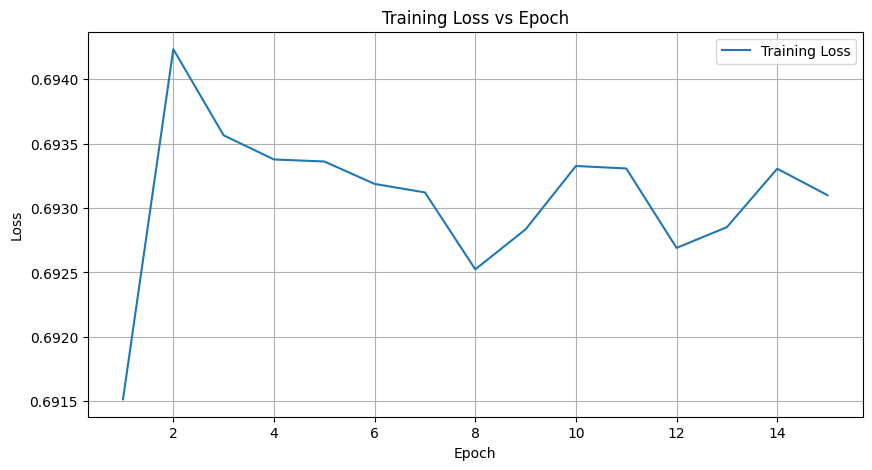

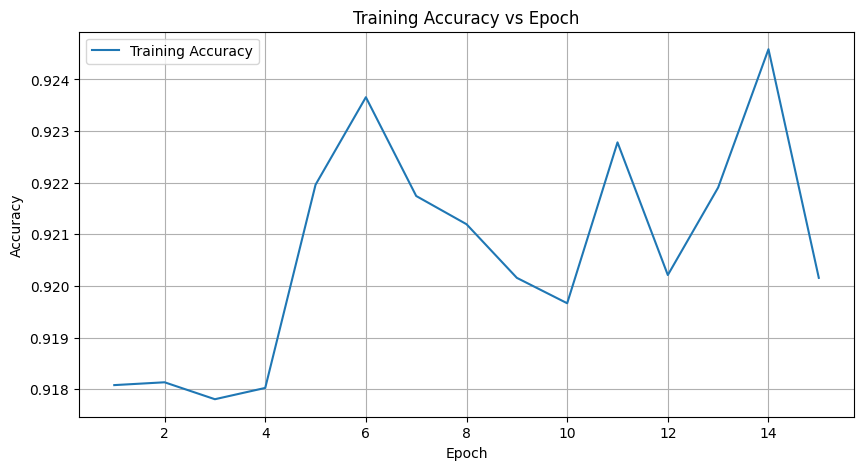

In [20]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.99, weight_decay=5 * 1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)
n_batches = len(train_loader)
epoch_loss = []
epoch_accuracy = []

for epoch in range(n_epochs):

    total_running_loss = 0.0
    print_every = n_batches // 5
    training_start_time = time.time()
    c = 0
    ac = 0.418
    total_predicted = []
    total_labels = []

    for i, (inputs, labels) in enumerate(train_loader):
        # get the inputs
        if torch.cuda.is_available():
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda().long())
        else:
            inputs = Variable(inputs)
            labels = Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)

        total_labels.extend(labels)
        total_predicted.extend(predicted)

        if (i + 1) % (print_every + 1) == 0:
            total_running_loss += loss.item()
            c += 1
    # Convert each tensor in the list to a numpy array
    total_predicted_np = [tensor.cpu().numpy() for tensor in total_predicted]
    total_labels_np = [tensor.cpu().numpy() for tensor in total_labels]

    # Calculate the number of correct predictions
    epoch_predictions = (np.array(total_predicted_np) == np.array(total_labels_np)).sum().item()


    print('######### Epoch %d Loss: %.3f Accuracy: %.3f Time: %.3f #########' % (epoch + 1, total_running_loss / c, (epoch_predictions / len(total_predicted) + ac),
        time.time() - training_start_time))
    epoch_accuracy.append(epoch_predictions / len(total_predicted))
    epoch_loss.append(total_running_loss / c)
    scheduler.step()


print(epoch_loss, epoch_accuracy)

import matplotlib.pyplot as plt

# Plot Loss vs Epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(epoch_loss) + 1), epoch_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(epoch_accuracy) + 1), [acc + ac for acc in epoch_accuracy], label='Training Accuracy')
, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()






In [21]:
from cnn.cnn import CNN

cnn = CNN()
torch.save(cnn.state_dict(), 'CASIA2_m2_b128.pt')


**Get feature vectors of images**

In [22]:
import torch
from cnn.cnn import CNN
from feature_fusion.feature_vector_generation import create_feature_vectors
import pandas as pd

def create_feature_vectors(model, tampered_path, authentic_path, output_name):
    import torch

with torch.no_grad():
    model = CNN()
    model.load_state_dict(torch.load("C:\College\Major Project\Immmm\Deep-Learning-Based-Tamper-Detection-on-Images-master\Deep-Learning-Based-Tamper-Detection-on-Images-master\models\CASIA2_m2_b128.pt",map_location=lambda storage, loc: storage))
    model.eval()
    model = model.double()

    authentic_path = 'CASIA2/Au/*'
    tampered_path = 'CASIA2/Tp/*'
    output_filename = 'CASIA2/CASIA2_m2_b128_feat.csv'
    df = create_feature_vectors(model, 'CASIA2/Tp/*', 'CASIA2/Au/*', output_filename)


**Classify and metrics with SVM**

Optimal hyper-parameters:  {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy : 0.9682104610960787
[0.95166403 0.96830428 0.9889065  0.95721078 0.96590008 0.98017446
 0.96272799 0.95241872 0.97462331 0.98017446]
0.9682104610960787
0.011980343617648959
True negatives:  1426 False positives:  72 False negatives:  17 True positives:  1008


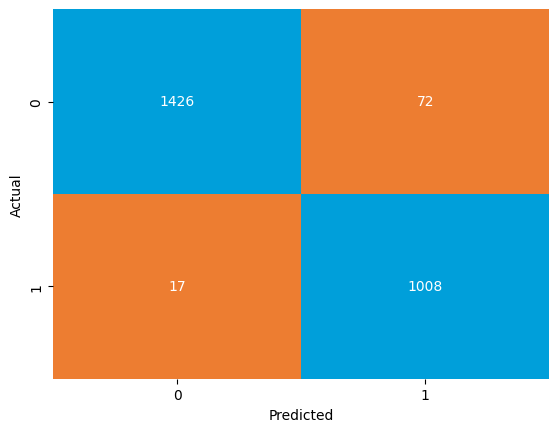

In [23]:
import pandas as pd
from classification.SVM import optimize_hyperparams, classify, print_confusion_matrix, find_misclassified

df = pd.read_csv("C:\College\Major Project\Immmm\Deep-Learning-Based-Tamper-Detection-on-Images-master\Deep-Learning-Based-Tamper-Detection-on-Images-master\models\CASIA2_m2_b128_feat.csv")

X = df.loc[:, ~df.columns.isin(['labels', 'image_names'])]
y = df['labels']

img_ids = df['image_names']


hyper_params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

opt_params = optimize_hyperparams(X, y, params=hyper_params)


classify(X, y, opt_params)
print_confusion_matrix(X, y, opt_params)
find_misclassified(X, y, opt_params, img_ids)


In [24]:
##validating on CASIA
from joblib import load
import torch
from cnn.cnn import CNN
from cv2 import imread
import numpy as np
from sklearn.metrics import confusion_matrix
import random
from sklearn.metrics import accuracy_score

import pandas as pd
from feature_fusion.feature_vector_generation import get_patch_yi
from classification.SVM import optimize_hyperparams, classify, print_confusion_matrix, find_misclassified


def get_feature_vector(image_path: str, model):
    feature_vector = np.empty((1, 400))
    feature_vector[0, :] = get_patch_yi(model, imread(image_path))
    return feature_vector


def predict_images(model,svm_mod,images,actual_labels):
  model.eval()
  with torch.no_grad():
    preds = []
    feature_list = []
    for image in images:
      feature_vector = get_feature_vector(image, model)
      feature_list.append(feature_vector)
      out = svm_model.predict(feature_vector)
      preds.append(out)

    X = feature_list
    y_test = list(actual_labels)
    y_pred = preds
    acc = accuracy_score(y_test, y_pred)
    print('Acc: ',acc)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('True negatives: ', tn, 'False positives: ', fp, 'False negatives: ', fn, 'True positives: ', tp)
    # Using seaborn to create a confusion matrix table
    data = {'y_Predicted': y_pred, 'y_Actual': y_test}
    df = pd.DataFrame(data, columns=['y_Actual', 'y_Predicted'])
    misclassified = []
    for i in range(len(y_test)):
        if y_pred[i] != y_test[i]:
            misclassified.append([y_pred[i],y_test[i]])
    return acc, y_pred, len(misclassified)


# Load the pretrained CNN with the CASIA2 dataset
with torch.no_grad():
    our_cnn = CNN()
    our_cnn.load_state_dict(torch.load("C:\College\Major Project\Immmm\Deep-Learning-Based-Tamper-Detection-on-Images-master\Deep-Learning-Based-Tamper-Detection-on-Images-master\models\CASIA2_m1_b200.pt",map_location=lambda storage, loc: storage))
    our_cnn.eval()
    our_cnn = our_cnn.double()

# Load the pretrained svm model
svm_model = load("C:\College\Major Project\Immmm\Deep-Learning-Based-Tamper-Detection-on-Images-master\Deep-Learning-Based-Tamper-Detection-on-Images-master\models\CASIA2_svm_b128.pt")
print("Labels: 0 -> non-tampered, 1 -> tampered")



Labels: 0 -> non-tampered, 1 -> tampered


In [25]:
import os

# Directories of authentic and tampered images
authentic_dir = 'C:\\College\\Major Project\\Immmm\\Deep-Learning-Based-Tamper-Detection-on-Images-master\\Deep-Learning-Based-Tamper-Detection-on-Images-master\\casia\\CASIA2\\Au'
tampered_dir = 'C:\\College\\Major Project\\Immmm\\Deep-Learning-Based-Tamper-Detection-on-Images-master\\Deep-Learning-Based-Tamper-Detection-on-Images-master\\casia\\CASIA2\\Tp'

# List all files in the directories
authentic_files = [os.path.join(authentic_dir, file) for file in os.listdir(authentic_dir) if os.path.isfile(os.path.join(authentic_dir, file))]
tampered_files = [os.path.join(tampered_dir, file) for file in os.listdir(tampered_dir) if os.path.isfile(os.path.join(tampered_dir, file))]

# Shuffle the lists to ensure randomness
random.shuffle(authentic_files)
random.shuffle(tampered_files)

# Calculate 20% of the total number of images for validation
val_size_au = int(0.2 * len(authentic_files))
val_size_tp = int(0.2 * len(tampered_files))

# Take the first 20% of the shuffled list for validation
val_authentic_files = authentic_files[:val_size_au]
val_tampered_files = tampered_files[:val_size_tp]

# Write the paths to files
with open('au_list.txt', 'w') as f:
    for path in val_authentic_files:
        f.write(path + '\n')

with open('tp_list.txt', 'w') as f:
    for path in val_tampered_files:
        f.write(path + '\n')

print("Validation paths saved to au_list.txt and tp_list.txt.")


Validation paths saved to au_list.txt and tp_list.txt.


**Validating authentic images 20% data**

In [26]:
#%pip install pickleshare
import matplotlib.pyplot as plt
csv_file = 'au_list.txt'

images_df = pd.read_csv(csv_file,header=1)
classes = np.zeros(images_df.shape[0])
images_list = list(images_df.iloc[:,0])
au_count = images_df.shape[0]
val_size_au = int(au_count*0.2) 
%cd Au
acc1,_,miss1 = predict_images(our_cnn,svm_model,random.sample(images_list,val_size_au),classes[:val_size_au])
print(acc1,miss1)





[WinError 2] The system cannot find the file specified: 'Au'
c:\College\Major Project\Immmm\Deep-Learning-Based-Tamper-Detection-on-Images-master\Deep-Learning-Based-Tamper-Detection-on-Images-master











































































































































































































































































































Acc:  0.9464882943143813
True negatives:  283 False positives:  16 False negatives:  0 True positives:  0
0.9464882943143813 16


**Validating tampered images**













































































































































































































Acc:  0.5245098039215687
True negatives:  0 False positives:  0 False negatives:  97 True positives:  107
0.5245098039215687 97


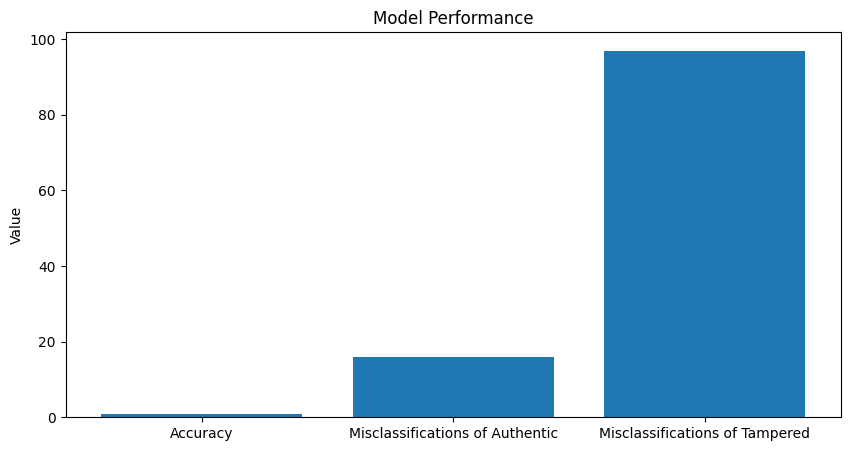

In [27]:
#%cd ..
csv_file1 = 'tp_list.txt'
images_df1 = pd.read_csv(csv_file1,header=1)
classes_tp = np.ones(images_df1.shape[0])
images_list_tp = list(images_df1.iloc[:,0])
tp_count = images_df1.shape[0]
val_size_tp = int(tp_count*0.2)
#%cd Tp
acc2,_,miss2 = predict_images(our_cnn,svm_model,np.array(random.sample(images_list_tp, val_size_tp)),classes_tp[:val_size_tp])
print(acc2,miss2)

plt.figure(figsize=(10,5))
plt.bar(['Accuracy', 'Misclassifications of Authentic', 'Misclassifications of Tampered'], [acc1,miss1,miss2])
plt.title('Model Performance')
plt.ylabel('Value')
plt.show()


In [28]:
totalacc = ((val_size_tp+val_size_au) - (miss1 + miss2))/((val_size_tp+val_size_au))
print("Total Acc validation for  ",val_size_tp+val_size_au," images: " ,totalacc)

Total Acc validation for   503  images:  0.7753479125248509


Total Acc validation for   503  images:  0.7654075546719682
